## Load Device

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter 
import scipy
from matplotlib import cm as CM
import torch
%matplotlib inline

## Create gaussian distribution

In [3]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    # print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    # pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
    pts = np.vstack((np.nonzero(gt)[1], np.nonzero(gt)[0])).T

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

## Load data and generate ground truth

In [4]:
root = './ShanghaiTech/'

In [5]:
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_train_mat = os.path.join(root,'part_A/train_data','ground-truth')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_A_test_mat = os.path.join(root,'part_A/test_data','ground-truth')
# part_B_train = os.path.join(root,'part_B/train_data','images')
# part_B_test = os.path.join(root,'part_B/test_data','images')
# path_sets = [part_A_train,part_A_test]

testerdir = os.path.join(root,'test/test_data','images')
testerdir_mat = os.path.join(root,'test/test_data','ground-truth')


In [6]:
def plot_density_map(density):
  groundtruth = np.asarray(density)
  plt.imshow(groundtruth,cmap=CM.jet)

### Custom dataset

In [10]:
import os
import pandas as pd
import fnmatch
from torchvision.io import read_image
from torchvision.io import ImageReadMode

dictCache = {}

class ImageMatDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, mat_dir, transform=None, target_transform=None):
        # self.img_labels = pd.read_csv(annotations_file)
        self.mat_dir = mat_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.img_dir), '*.*'))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"IMG_{idx+1}.jpg")
        image = read_image(img_path, mode=ImageReadMode.RGB)
        image = image.to(dtype = torch.float)
        mat_path = os.path.join(self.mat_dir, f"GT_IMG_{idx+1}.mat")
        mat = io.loadmat(mat_path)

        if mat_path in dictCache:
          k = dictCache[mat_path]
        else:
          sh1 = image.shape[1]
          sh2 = image.shape[2]
          k = np.zeros((sh1,sh2))

          gt = mat["image_info"][0,0][0,0][0]

          for i in range(0,len(gt)):
              if int(gt[i][1])<sh1 and int(gt[i][0])<sh2:
                  k[int(gt[i][1]),int(gt[i][0])]=1
          # print("before gauss")
          k = gaussian_filter_density(k)
          # print("after gauss")
          # k = np.asarray(k)
          dictCache[mat_path] = k 

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            k = self.target_transform(k)
        return image, k

### load datasets

In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import multiprocessing as mp
import numpy as np
import random
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
# (180, 300)
sizeY = int(768/2)
sizeX = int(1024/2)

use_from_total = 1
seed_ = 41
use_val = True
batch_size = 16
transform = transforms.Compose([
                                transforms.Resize(sizeX), 
                                transforms.CenterCrop((sizeY, sizeX)),
                                transforms.Normalize(mean=(0,)*3, std=(255,)*3)
                              ]) 
transform2 = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize(sizeX), 
                                transforms.CenterCrop((sizeY, sizeX)),
                                transforms.ToTensor()
                              ]) 


#* load image and mask folders, print class dict
print("Loading Dataset...")
dataset = ImageMatDataset(img_dir=part_A_train, mat_dir=part_A_train_mat, transform=transform, target_transform=transform2)
dataset_test = ImageMatDataset(img_dir=part_A_test, mat_dir=part_A_test_mat, transform=transform, target_transform=transform2)

tester = ImageMatDataset(img_dir=testerdir, mat_dir=testerdir_mat, transform=transform, target_transform=transform2)


Loading Dataset...


## Pre-calculate density to file

In [ ]:
import pickle
file = open("dictCache.pck", "wb")

print(len(dataset))
for i in range(len(dataset)):
  print(i)
  print(dataset[i][1].shape)

pickle.dump(dictCache, file)
print(len(dataset_test))
for i in range(len(dataset_test)):
  print(i)
  print(dataset_test[i][1].shape)
pickle.dump(dictCache, file)

file.close()

## Load precalculated density

In [12]:
import pickle
file = open("preCalcDensity.pck", "rb")
dictCache = pickle.load(file)
file.close()

## Visualize ground_value density and count

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 384, 512)
0.13407254
<class 'float'>
crowd count: 236.45628


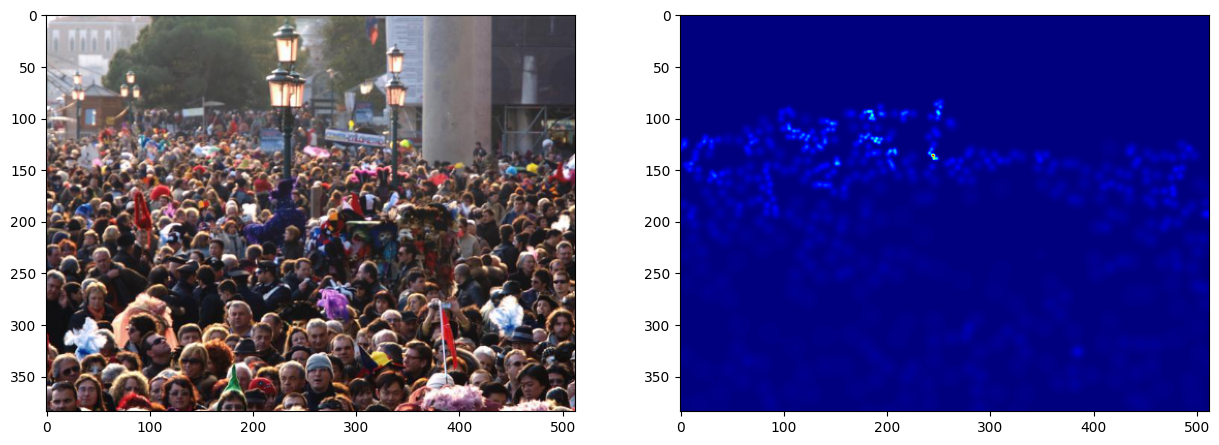

In [13]:
img, density = dataset[1]
print(np.asarray(density).shape)
f, axarr = plt.subplots(1,2, figsize=(15, 15))
# print(np.asarray(density))
print(np.max(np.asarray(density)))

print(type(img[0][0][0].item()))
axarr[0].imshow(img.permute(1, 2, 0)  )
plot_density_map(density.permute(1, 2, 0))
print("crowd count:", np.sum(np.asarray(density)))

In [ ]:
# np.asarray(density)

## Data Loaders

In [14]:
import random
seed_ = 41
batch_size = 1 # 16
def seed_worker(worker_id):
      worker_seed = torch.initial_seed() % 2**32
      np.random.seed(worker_seed)
      random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_)

#* final data loaders 
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g)
# val_loader = DataLoader(dataset=val_masked_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g) 
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g) 

tester_loader = DataLoader(dataset=tester, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g) 

## Models

#### densenet model

In [15]:
from torchvision import datasets, models
import torch.nn.functional as F
from torch import Tensor


def CNN_DenseNet(pretrained=False):
    model = models.densenet121(
        # weights="IMAGENET1K_V1"
    )  # Densenet121 model pretrained on ImageNet1K
    num_ftrs = model.classifier.in_features  # densenet output
    # model.features[3] = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False,return_indices=True)

    print(num_ftrs)
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 32), # fully connected output to num_classes
        nn.Linear(32, 96 * 128),  # fully connected output to num_classes
        nn.Unflatten(1, torch.Size([1, 96, 128])), # dropout?
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(1, 64, 4, stride=4, padding=0),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
        nn.ConvTranspose2d(64, 1, 2, stride=2, padding=0),
        # nn.ReLU(inplace=True),
        nn.Sigmoid()
        # nn.ConvTranspose2d(64, 1, 7, stride=2, padding=3,bias=True),
        # nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1),
        # nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1),
        # nn.ConvTranspose2d(64, 64, 7, stride=2, padding=3)
        # nn.MaxUnpool2d(kernel_size=3, stride=2, padding=1),
        # nn.ReLU(inplace=True),
        # nn.MaxUnpool2d(kernel_size=3, stride=2, padding=1),
        # nn.ReLU(inplace=True),

        # nn.ReLU(inplace=True)
        # nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        # nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      )
    
    # def new_forward(self, x: Tensor) -> Tensor:
    #     features, indices = self.features(x)
    #     out = F.relu(features, inplace=True)
    #     out = F.adaptive_avg_pool2d(out, (1, 1))
    #     out = torch.flatten(out, 1)
    #     out = self.classifier(out)
    #     print("custom!")
    #     return out

    # bound_method = new_forward.__get__(model, model.__class__)
    # setattr(model, 'forward', bound_method)

    model = model.to(device)  # send to gpu
    return model

#### UNet model

In [16]:
from typing import Tuple

import numpy as np
import torch
from torch import nn

def conv_block(channels: Tuple[int, int],
               size: Tuple[int, int],
               stride: Tuple[int, int]=(1, 1),
               N: int=1):
    """
    Create a block with N convolutional layers with ReLU activation function.
    The first layer is IN x OUT, and all others - OUT x OUT.

    Args:
        channels: (IN, OUT) - no. of input and output channels
        size: kernel size (fixed for all convolution in a block)
        stride: stride (fixed for all convolution in a block)
        N: no. of convolutional layers

    Returns:
        A sequential container of N convolutional layers.
    """
    # a single convolution + batch normalization + ReLU block
    block = lambda in_channels: nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=channels[1],
                  kernel_size=size,
                  stride=stride,
                  bias=False,
                  padding=(size[0] // 2, size[1] // 2)),
        nn.BatchNorm2d(num_features=channels[1]),
        nn.ReLU()
    )
    # create and return a sequential container of convolutional layers
    # input size = channels[0] for first block and channels[1] for all others
    return nn.Sequential(*[block(channels[bool(i)]) for i in range(N)])


class ConvCat(nn.Module):
    """Convolution with upsampling + concatenate block."""

    def __init__(self,
                 channels: Tuple[int, int],
                 size: Tuple[int, int],
                 stride: Tuple[int, int]=(1, 1),
                 N: int=1):
        """
        Create a sequential container with convolutional block (see conv_block)
        with N convolutional layers and upsampling by factor 2.
        """
        super(ConvCat, self).__init__()
        self.conv = nn.Sequential(
            conv_block(channels, size, stride, N),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, to_conv: torch.Tensor, to_cat: torch.Tensor):
        """Forward pass.

        Args:
            to_conv: input passed to convolutional block and upsampling
            to_cat: input concatenated with the output of a conv block
        """
        return torch.cat([self.conv(to_conv), to_cat], dim=1)


class UNet(nn.Module):
    """
    U-Net implementation.

    Ref. O. Ronneberger et al. "U-net: Convolutional networks for biomedical
    image segmentation."
    """

    def __init__(self, filters: int=64, input_filters: int=3, **kwargs):
        """
        Create U-Net model with:

            * fixed kernel size = (3, 3)
            * fixed max pooling kernel size = (2, 2) and upsampling factor = 2
            * fixed no. of convolutional layers per block = 2 (see conv_block)
            * constant no. of filters for convolutional layers

        Args:
            filters: no. of filters for convolutional layers
            input_filters: no. of input channels
        """
        super(UNet, self).__init__()
        # first block channels size
        initial_filters = (input_filters, filters)
        # channels size for downsampling
        down_filters = (filters, filters)
        # channels size for upsampling (input doubled because of concatenate)
        up_filters = (2 * filters, filters)

        # downsampling
        self.block1 = conv_block(channels=initial_filters, size=(3, 3), N=2)
        self.block2 = conv_block(channels=down_filters, size=(3, 3), N=2)
        self.block3 = conv_block(channels=down_filters, size=(3, 3), N=2)

        # upsampling
        self.block4 = ConvCat(channels=down_filters, size=(3, 3), N=2)
        self.block5 = ConvCat(channels=up_filters, size=(3, 3), N=2)
        self.block6 = ConvCat(channels=up_filters, size=(3, 3), N=2)

        # density prediction
        self.block7 = conv_block(channels=up_filters, size=(3, 3), N=2)
        self.density_pred = nn.Conv2d(in_channels=filters, out_channels=1,
                                      kernel_size=(1, 1), bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        """Forward pass."""
        # use the same max pooling kernel size (2, 2) across the network
        pool = nn.MaxPool2d(2)

        # downsampling
        block1 = self.block1(input)
        pool1 = pool(block1)
        block2 = self.block2(pool1)
        pool2 = pool(block2)
        block3 = self.block3(pool2)
        pool3 = pool(block3)

        # upsampling
        block4 = self.block4(pool3, block3)
        block5 = self.block5(block4, block2)
        block6 = self.block6(block5, block1)

        # density prediction
        block7 = self.block7(block6)
        return self.sigmoid(self.density_pred(block7))


## Create model, loss fn and optimizer

In [17]:
# model = CNN_DenseNet().to(device)
model = UNet(input_filters=3).to(device)

learning_rate = 0.001 
weight_decay_ = 0.001

# model = model.cuda()

# loss_fn = nn.MSELoss(reduction='sum')
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=0.9,
                                weight_decay=1e-5)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                 step_size=20,
#                                                 gamma=0.1)

# loss_fn = nn.NLLLoss()
# loss_fn = nn.BCELoss()
# loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
#                           momentum=0.9,
#                           weight_decay=weight_decay_)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)



In [18]:
print(model)

UNet(
  (block1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (block2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (block3): Sequential(
    (0): Sequen

## Train/Val loop

In [21]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
import torch.nn.functional as F

model_path = "./model_checkpoint.pth"
early_stopped_at = 0
patience = 5
USE_MASKS = False
use_early_stopping = True

def train(model, optimizer, loss_fn, num_epochs):

  total_step = len(train_loader)
  print("total steps:", total_step)
  print("epochs:", num_epochs)

  #* Epoch loss history
  epoch_train_loss = []
  epoch_val_loss = []
  last_loss = 0
  last_vloss = 0

  #* Early stopping params
  best_score = None
  counter = 0
  global patience
  global early_stopped_at
  early_stopped_at = 0
  
  print("Training Starting...")

  for epoch in range(num_epochs):
    if epoch > 0: 
      print("last train loss:", last_loss, "last val loss:", last_vloss)

    last_loss = 0
    last_vloss = 0
    print("\nStarting epoch:", epoch+1)
    
    #* TRAINING
    len_loss = 0
    for i, (images, density) in enumerate(train_loader):
    # for i, (images, density) in enumerate(tester):
      # pl.clf()
    
      #* to device
      images = images.to(device)
      density = density.to(device)

      #* forward
      # images = images.reshape(1, 3, int(768/2), int(1024/2))
      # print(density.shape)
      # density = density.reshape(1, 1, int(768/2), int(1024/2))

      output = model(images)
      loss   = loss_fn(output, density)

      count_actual = np.sum(np.asarray(density.cpu().detach().numpy()))
      count_pred = np.sum(np.asarray(output.cpu().detach().numpy()))

      # if count_pred < count_actual:
      #   print("loss before:", loss.item())
      #   loss = loss * 10 * np.abs(count_pred - count_actual)
      #   print("loss after:", loss.item())


      #* change the params
    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
            
      #* add up loss
      last_loss += (loss.item())
      len_loss += 1
            
      # f, axarr = plt.subplots(1,2, figsize=(15, 15))
      # temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
      # axarr[0].imshow(temp,cmap=CM.jet)
      # temp = np.asarray(density.detach().cpu().reshape(density.detach().cpu().shape[2],density.detach().cpu().shape[3]))
      # axarr[1].imshow(temp,cmap=CM.jet)

      # display.display(pl.gcf())
      # time.sleep(1.0)
      # plt.close()
      if (i+1) % 100 == 0 or i == 0:
        print("predicted vs actual:")
        pl.clf()
        f, axarr = plt.subplots(1,2, figsize=(15, 15))
        temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
        sc1 = axarr[0].imshow(temp,cmap=CM.jet)
        f.colorbar(sc1, ax=axarr[0], orientation="horizontal")

        temp = np.asarray(density.detach().cpu().reshape(density.detach().cpu().shape[2],density.detach().cpu().shape[3]))
        sc2 = axarr[1].imshow(temp,cmap=CM.jet)
        f.colorbar(sc2, ax=axarr[1], orientation="horizontal")
        display.display(pl.gcf())
        plt.close()


        print ('\nEpoch [{}/{}], Step [{}/{}], Current Average Loss: {:.4f}' 
              .format(epoch+1, num_epochs, i+1, total_step, (last_loss)/(len_loss)))
        print("last loss:", loss.item())
        print("last crowd count actual:", count_actual)
        print("last crowd count predicted:", count_pred)

      print("|", end ="")


      del images
      del density
      del output
      del loss
      torch.cuda.empty_cache()
      
    last_loss = (last_loss)/(len_loss)
    epoch_train_loss.append(last_loss)


    # pl.plot(range(len(epoch_train_loss)), epoch_train_loss, label="train loss") 
    
    # if use_val:
    #   #* VALIDATION
    #   with torch.no_grad():
    #     len_vloss = 0
    #     for i, ((vimages, vlabels), (vimages_mask, _)) in enumerate(val_loader):
    #       #* masks
    #       if USE_MASKS:
    #         vmasked_images = torch.mul(vimages, vimages_mask)
    #       else:
    #         vmasked_images = vimages 
          
    #       #* to device
    #       vmasked_images = vmasked_images.to(device)
    #       vlabels = vlabels.to(device)

    #       #* forward
    #       output = model(vmasked_images)
    #       vloss   = loss_fn(output, vlabels)
    
    #       #* add up loss
    #       last_vloss += (vloss.item())
    #       len_vloss += 1

    #       if (i+1) % 100 == 0 or i == 0:
    #               print ('\nVal Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
    #                     .format(epoch+1, num_epochs, i+1, len(val_loader), (last_vloss)/(len_vloss)))
    #       print("|", end ="")

    #   last_vloss = (last_vloss)/(len_vloss)
    #   epoch_val_loss.append(last_vloss)
    #   pl.plot(range(len(epoch_val_loss)), epoch_val_loss, label="validation loss")

    #   #* Early stopping
    #   if use_early_stopping:
    #     if best_score is None:
    #       best_score = last_vloss
    #     else:
    #         # Check if val_loss improves or not.
    #         if last_vloss < best_score:
    #             # val_loss improves, we update the latest best_score, 
    #             # and save the current model
    #             best_score = last_vloss
    #             torch.save({'state_dict':model.state_dict()}, model_path)
    #         else:
    #             # val_loss does not improve, we increase the counter, 
    #             # stop training if it exceeds the amount of patience
    #             counter += 1
    #             if counter >= patience:
    #               print("\tEarly Stopped")
    #               early_stopped_at = epoch + 1
    #               break

    # pl.xlabel('epochs')
    # pl.ylabel('loss')
    # pl.title("Loss over Iteration")
    # pl.legend(loc="upper right")
    # display.clear_output(wait=True) 
    # display.display(pl.gcf())
    # time.sleep(1.0)
    # plt.close()
  
  print('\nFinished Training Trainset')
  print("last train loss:", last_loss, "last val loss:", last_vloss)
  
  # Load best model 
  # if use_early_stopping: # if use_val
  #   if num_epochs != 0:
  #     print('loading best model before testing.')
  #     model_checkpoint = torch.load(model_path)
  #     model.load_state_dict(model_checkpoint['state_dict'])
    
  return epoch_train_loss, epoch_val_loss

## Train the model for n epochs

total steps: 300
epochs: 60
Training Starting...

Starting epoch: 1
predicted vs actual:



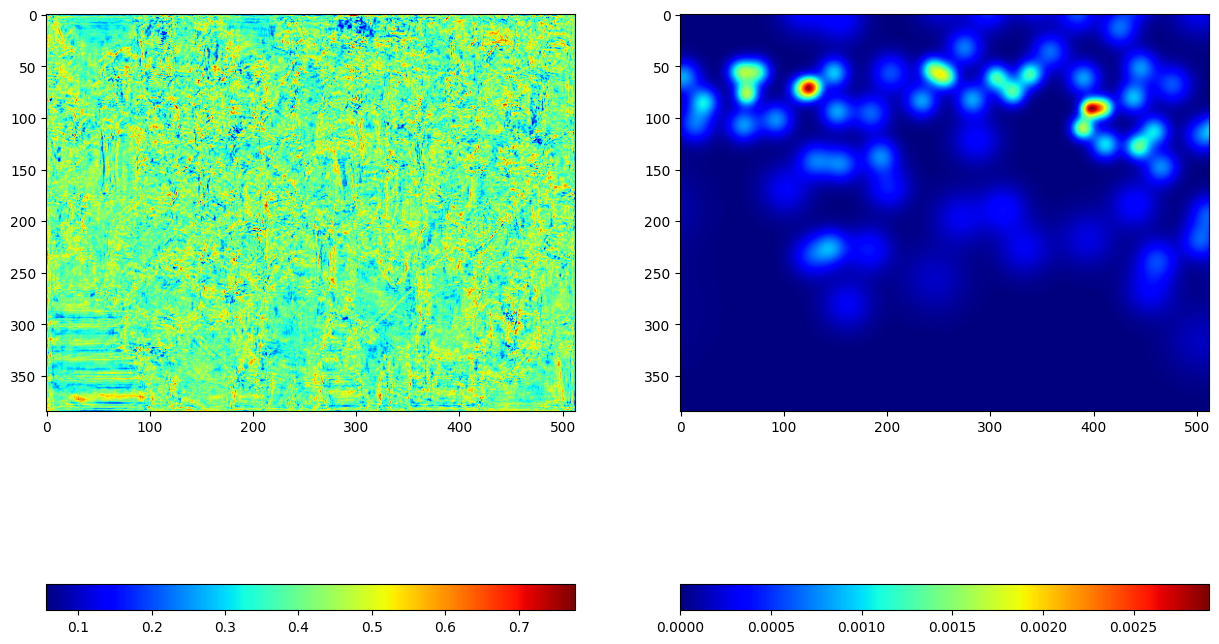


Epoch [1/60], Step [1/300], Current Average Loss: 0.1700
last loss: 0.16996750235557556
last crowd count actual: 33.048214
last crowd count predicted: 79794.195
|||||||||||||||||||||||||||

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [22]:
train(model, optimizer, loss_fn, 60)

### tests, write model to file and load

In [ ]:
model_path = "./last_trained_model.pth"
torch.save({'state_dict':model.state_dict()}, model_path)

In [ ]:
model_checkpoint = torch.load("./last_trained_model.pth")
model.load_state_dict(model_checkpoint['state_dict'])

### testing the model


In [ ]:
for i, (images, density) in enumerate(test_loader):
  print(i)
  # images = images.to(device, dtype=float)
  images = images.to(device)
  density = density.to(device)

  # print(images.shape)
  # print(type(images))
  output = model(images)
  # print(output.shape)
  # print(output)
  # print(density.shape)
  # print(density)

  # optimizer.zero_grad()
  # output = output * 0
  loss   = loss_fn(output, density)
  count_actual = np.sum(np.asarray(density.cpu().detach().numpy()))
  count_pred = np.sum(np.asarray(output.cpu().detach().numpy()))
  # if count_pred < count_actual:
  #   print("loss before:", loss.item())
  #   loss = loss * 10 * np.abs(count_pred - count_actual)
  #   print("loss after:", loss.item())


  #* change the params
  print("last loss:", loss.item())
  print("crowd count actual:", count_actual)
  print("crowd count predicted:", count_pred)
  
  f, axarr = plt.subplots(1,2, figsize=(15, 15))
  temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
  sc1 = axarr[0].imshow(temp,cmap=CM.jet)
  f.colorbar(sc1, ax=axarr[0], orientation="horizontal")

  temp = np.asarray(density.detach().cpu().reshape(density.detach().cpu().shape[2],density.detach().cpu().shape[3]))
  sc2 = axarr[1].imshow(temp,cmap=CM.jet)
  f.colorbar(sc2, ax=axarr[1], orientation="horizontal")


  print(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
#   # last_loss += (loss.item())
#   # len_loss += 1

  del images
  del density
  del output
  del loss
  torch.cuda.empty_cache()
  # if i > 10:
  break

torch.cuda.empty_cache()

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(15, 15))
print(output)
# axarr[0].imshow(output[0].permute(1, 2, 0).cpu().detach().numpy() )
groundtruth = np.asarray(output.detach().cpu)
plt.imshow(groundtruth,cmap=CM.jet)
# print(output.cpu())

In [ ]:
print(output.shape)

## CSRNet

In [ ]:
import torch.nn as nn
import torch
from torchvision import models
# from utils import save_net,load_net

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        # if not load_weights:
        #     mod = models.vgg16(pretrained = True)
        #     self._initialize_weights()
        #     for i in range(len(self.frontend.state_dict().items())):
        #         self.frontend.state_dict().items()[i][1].data[:] = mod.state_dict().items()[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                           
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)                

In [ ]:
model = CSRNet()
print(model)